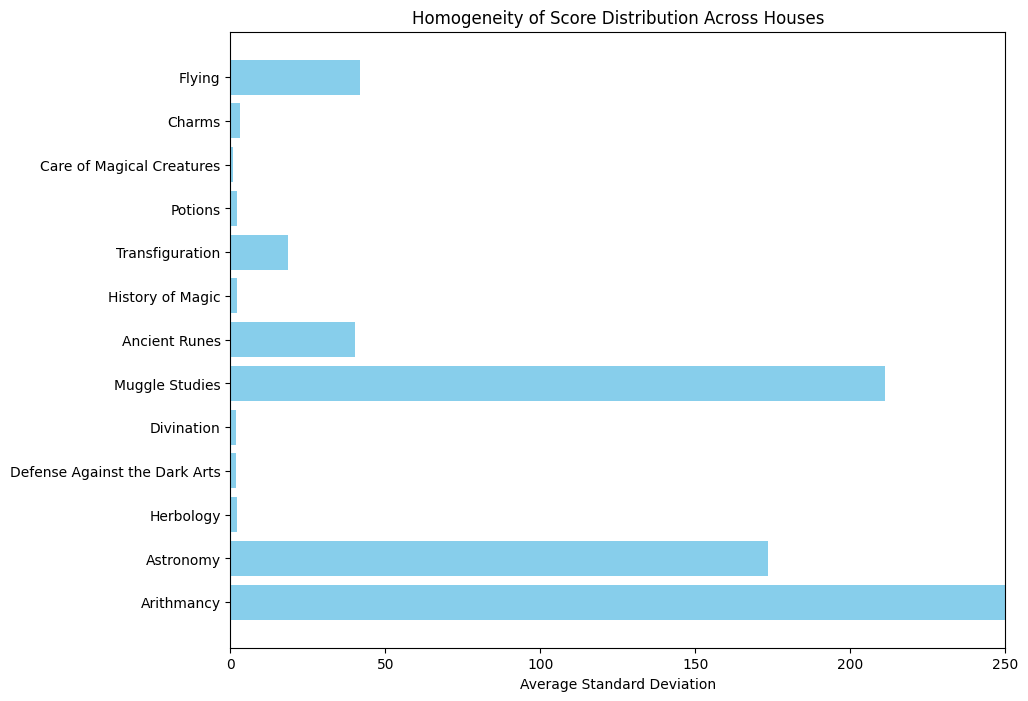

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

class dslr:
    def __init__(self, path) -> None:
        self.df = pd.read_csv(path)

    def describe(self) -> pd.DataFrame:        
        df = self.df.select_dtypes(include='number')
        df = df.drop(['Index'], axis=1)
        df = df.dropna(axis=1, how='all')
        results = {}
        
        for column_name, column_data in df.items():
            values = column_data.dropna().values
            sorted_values = np.sort(values)
            count = len(sorted_values)
            mean = np.sum(sorted_values) / count
            std = np.sqrt(np.sum((sorted_values - mean) ** 2) / count)
            min_val = sorted_values[0]
            q25 = np.percentile(sorted_values, 25)
            q50 = np.percentile(sorted_values, 50)
            q75 = np.percentile(sorted_values, 75)
            max_val = sorted_values[-1]
            
            results[column_name] = {
                "Count": count,
                "Mean": mean,
                "Std": std,
                "Min": min_val,
                "25%": q25,
                "50%": q50,
                "75%": q75,
                "Max": max_val
            }
        
        return pd.DataFrame(results)
    
    def histogram(self):        
        houses = self.df['Hogwarts House'].unique()
        courses = self.df.columns.drop(['Index', 'Hogwarts House', 'First Name', 'Last Name', 'Birthday', 'Best Hand'])

        avg_std_devs = {}
        for course in courses:
            std_devs = []
            for house in houses:
                # standard deviation of course scores for each house
                std_dev = self.df[self.df['Hogwarts House'] == house][course].std()
                std_devs.append(std_dev)
            # average standard deviation for the course across all houses
            avg_std_devs[course] = np.mean(std_devs)
        avg_stds = [avg_std_devs[course] for course in courses]

        plt.figure(figsize=(10, 8))
        plt.barh(courses, avg_stds, color='skyblue')
        plt.xlabel('Average Standard Deviation')
        plt.title('Homogeneity of Score Distribution Across Houses')
        plt.xlim(0, 250)
        plt.show()
        
    
test = dslr("datasets/dataset_train.csv")
test.histogram()